In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [3]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Select range of events
nmin=0
nmax=5000

#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]

#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 5000/5000 [00:03<00:00, 1285.12it/s]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


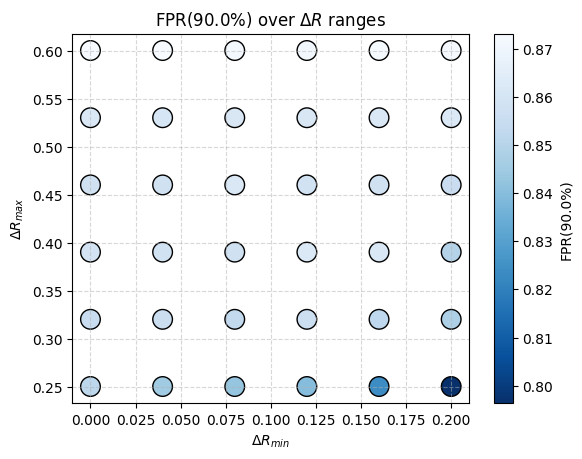

(array([[0.85170732, 0.85533333, 0.85895485, 0.85790118, 0.86192755,
         0.87285327],
        [0.845     , 0.85540541, 0.85831202, 0.85802216, 0.86037736,
         0.87307344],
        [0.84273319, 0.85321101, 0.85766614, 0.86183937, 0.86119765,
         0.87149817],
        [0.83990148, 0.8561747 , 0.86220044, 0.85836543, 0.86126761,
         0.87053021],
        [0.8236246 , 0.85223368, 0.86184597, 0.85765604, 0.86185642,
         0.87225361],
        [0.79634465, 0.84789311, 0.84944841, 0.85516913, 0.86208192,
         0.87210052]]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 ]),
 array([0.25, 0.32, 0.39, 0.46, 0.53, 0.6 ]))

In [4]:
ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta, ZeroBias_phi, steps=6, dr_max_range=[0.25,0.6], dr_min_range=[0,0.2])

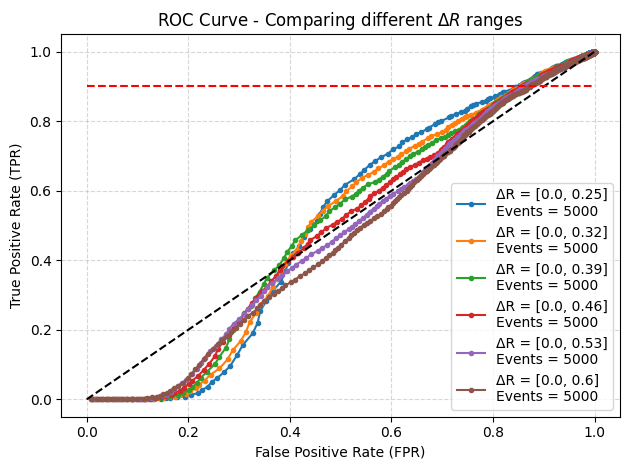

[[<Array [0.0166, 0.0371, 0.0517, 0.0693, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.0133, 0.0313, 0.0467, 0.0647, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.0122, 0.0269, 0.0416, 0.0553, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.011, 0.0216, 0.0327, 0.0445, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.00923, 0.0191, 0.0294, 0.04, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.00904, 0.0205, 0.0286, 0.0386, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>]]

In [5]:
plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta, ZeroBias_phi,
                [0, 5000],[0,5000], np.linspace(0,1,1000), dr_min=(0.0,0.0,0.0,0.0,0.0,0.0), dr_max=(0.25, 0.32, 0.39, 0.46, 0.53, 0.6))

In [6]:
ROC_FPR_efficiency(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt,
                    ZeroBias_eta, ZeroBias_phi, dr_min=0, dr_max=0.6)

(np.float64(0.8728532690569448), 0, 0.6)